In [197]:
from pathlib import Path
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import keras_preprocessing

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from imblearn.combine import SMOTEENN

In [198]:


def read_and_shuffle_data():
    full_data = pd.read_csv(Path().resolve().joinpath("dataset/full_data.csv"))

    shuffled = full_data.sample(frac=1, random_state=0)

    return shuffled


def impute_missing(data: DataFrame, header):
    enc = OrdinalEncoder()
    enc.fit(data)

    imputer = KNNImputer(n_neighbors=2, missing_values=np.nan, weights="uniform")
    smoking_status = imputer.fit_transform(enc.transform(data))
    
    smoking_status = DataFrame(enc.inverse_transform(smoking_status), columns=header)

    return smoking_status


def resample(data: pd.DataFrame):
    """ oversample positive cases with SMOTE and undersample negative with EEN """
    enc = OrdinalEncoder()
    enc.fit(data)
    data = DataFrame(enc.transform(data), columns=data.columns)

    X = data.drop(columns=['stroke'], axis=1)
    Y = data['stroke']

    smote_een = SMOTEENN(random_state=0, sampling_strategy='auto')

    x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled['stroke'] = y_resampled

    return DataFrame(enc.inverse_transform(x_resampled), columns=data.columns)


def generate_train_valid_test(shuffled_data_df: DataFrame):
    test_set = shuffled_data_df[4500:]

    train_validation_data = shuffled_data_df[:4500].sample(frac=1, random_state=0)
    
    train_set = resample(train_validation_data[:4000])
    validation_set = train_validation_data[4000:]

    return train_set, validation_set, test_set


def prepare_data_tvt(header):
    full_data_shuffled = read_and_shuffle_data()

    full_data_shuffled[
        ["hypertension", "heart_disease", "ever_married", "smoking_status", "stroke"]
    ] = (
        full_data_shuffled[
            [
                "hypertension",
                "heart_disease",
                "ever_married",
                "smoking_status",
                "stroke",
            ]
        ]
        .replace({1: "Yes", 0: "No", "Unknown": np.nan})
    ) # ensure they don't interfere with StringLookupLayers


    full_data_shuffled["smoking_status"] = impute_missing(
        full_data_shuffled, header=full_data_shuffled.columns
    )['smoking_status']


    train_df, validation_df, test_df = generate_train_valid_test(full_data_shuffled)

    test_df.to_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), index=False, header=False
    )

    validation_df.to_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"), index=False, header=False
    )

    train_df.to_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), index=False, header=False
    )
    
    return test_df, train_df, validation_df


In [199]:
# prepare data
CSV_HEADER = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "avg_glucose_level",
    "bmi",
    "smoking_status",
    "stroke",
]

train_data_path = Path().resolve().joinpath("dataset/train_data.csv")
validation_data_path = Path().resolve().joinpath("dataset/validation_data.csv")
test_data_path = Path().resolve().joinpath("dataset/test_data.csv")

train_data_file = str(train_data_path.absolute())
validation_data_file = str(validation_data_path.absolute())
test_data_file = str(test_data_path.absolute())

train_data = DataFrame()
validation_data = DataFrame()
test_data = DataFrame()

try:
    train_data = pd.read_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), names=CSV_HEADER
    )

    validation_data = pd.read_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"), names=CSV_HEADER
    )

    test_data = pd.read_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), names=CSV_HEADER
    )

except:
    test_data, train_data, validation_data = prepare_data_tvt(header=CSV_HEADER)


test_data, train_data, validation_data = prepare_data_tvt(header=CSV_HEADER)

print(
    f"Using {len(train_data)} samples for training, {len(validation_data)} for validation, and {len(test_data)} for test"
)

NUMERIC_FEATURE_NAMES = [
    "age",
    "avg_glucose_level",
    "bmi",
]  # list of numeric feature names

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": sorted(list(train_data["gender"].unique())),
    "hypertension": sorted(list(train_data["hypertension"].unique())),
    "heart_disease": sorted(list(train_data["heart_disease"].unique())),
    "ever_married": sorted(list(train_data["ever_married"].unique())),
    "work_type": sorted(list(train_data["work_type"].unique())),
    "Residence_type": sorted(list(train_data["Residence_type"].unique())),
    "smoking_status": sorted(list(train_data["smoking_status"].unique())),
}

# metadata

# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# The name of the target feature.
TARGET_FEATURE_NAME = "stroke"
# A list of the labels of the target features.
TARGET_LABELS = ["Yes", "No"]

MLP_MODEL_PATH=str(Path().resolve().joinpath('model/mlp_model'))
TABTRANSFORMER_MODEL_PATH=str(Path().resolve().joinpath('model/tabtransformer_model'))

Using 5970 samples for training, 500 for validation, and 481 for test


In [200]:
# model hyperparameters

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 100
EPOCHS_TO_WAIT_FOR_IMPROVE=3

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.


In [201]:
# data proccessing pipeline

target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    return features, target_index


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    """dataset from, csv"""
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [202]:
def create_model_inputs():
    """Create model inputs"""
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


def encode_inputs(inputs, embedding_dims):
    """Encode features"""

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    print(encoded_categorical_feature_list)

    return encoded_categorical_feature_list, numerical_feature_list


In [203]:
# training and evaluation


def run_experiment(
    model,
    train_data_file,
    test_data_file,
    model_output,
    num_epochs,
    learning_rate,
    batch_size,
):
    """Implement a training and evaluation procedure"""

    # optimizer = tfa.optimizers.AdamW(
    #    learning_rate=learning_rate, weight_decay=WEIGHT_DECAY
    # )
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS_TO_WAIT_FOR_IMPROVE)
    checkpoint_callback = keras.ModelCheckpoint(model_output, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")

    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    
    model.save(model_output)
    
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history, model


In [204]:
# MLP block
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    """MLP block"""

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    """MLP model without transformer layers"""

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.relu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_98')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_99')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_100')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_101')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_102')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_103')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_104')>]
Total model weights: 68115


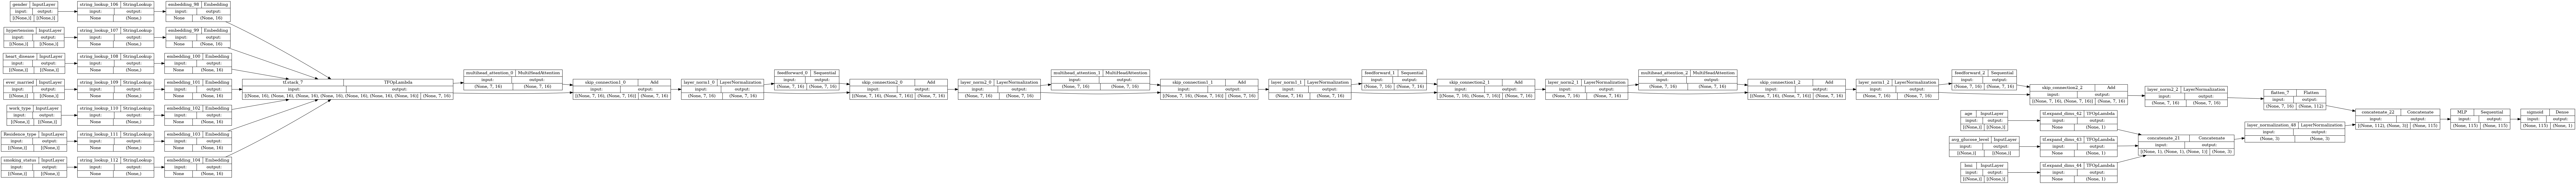

In [205]:
# tabtransformer block


def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
    # use_column_embedding=True
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_105')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_106')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_107')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_108')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_109')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_110')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_111')>]
Total model weights: 81233


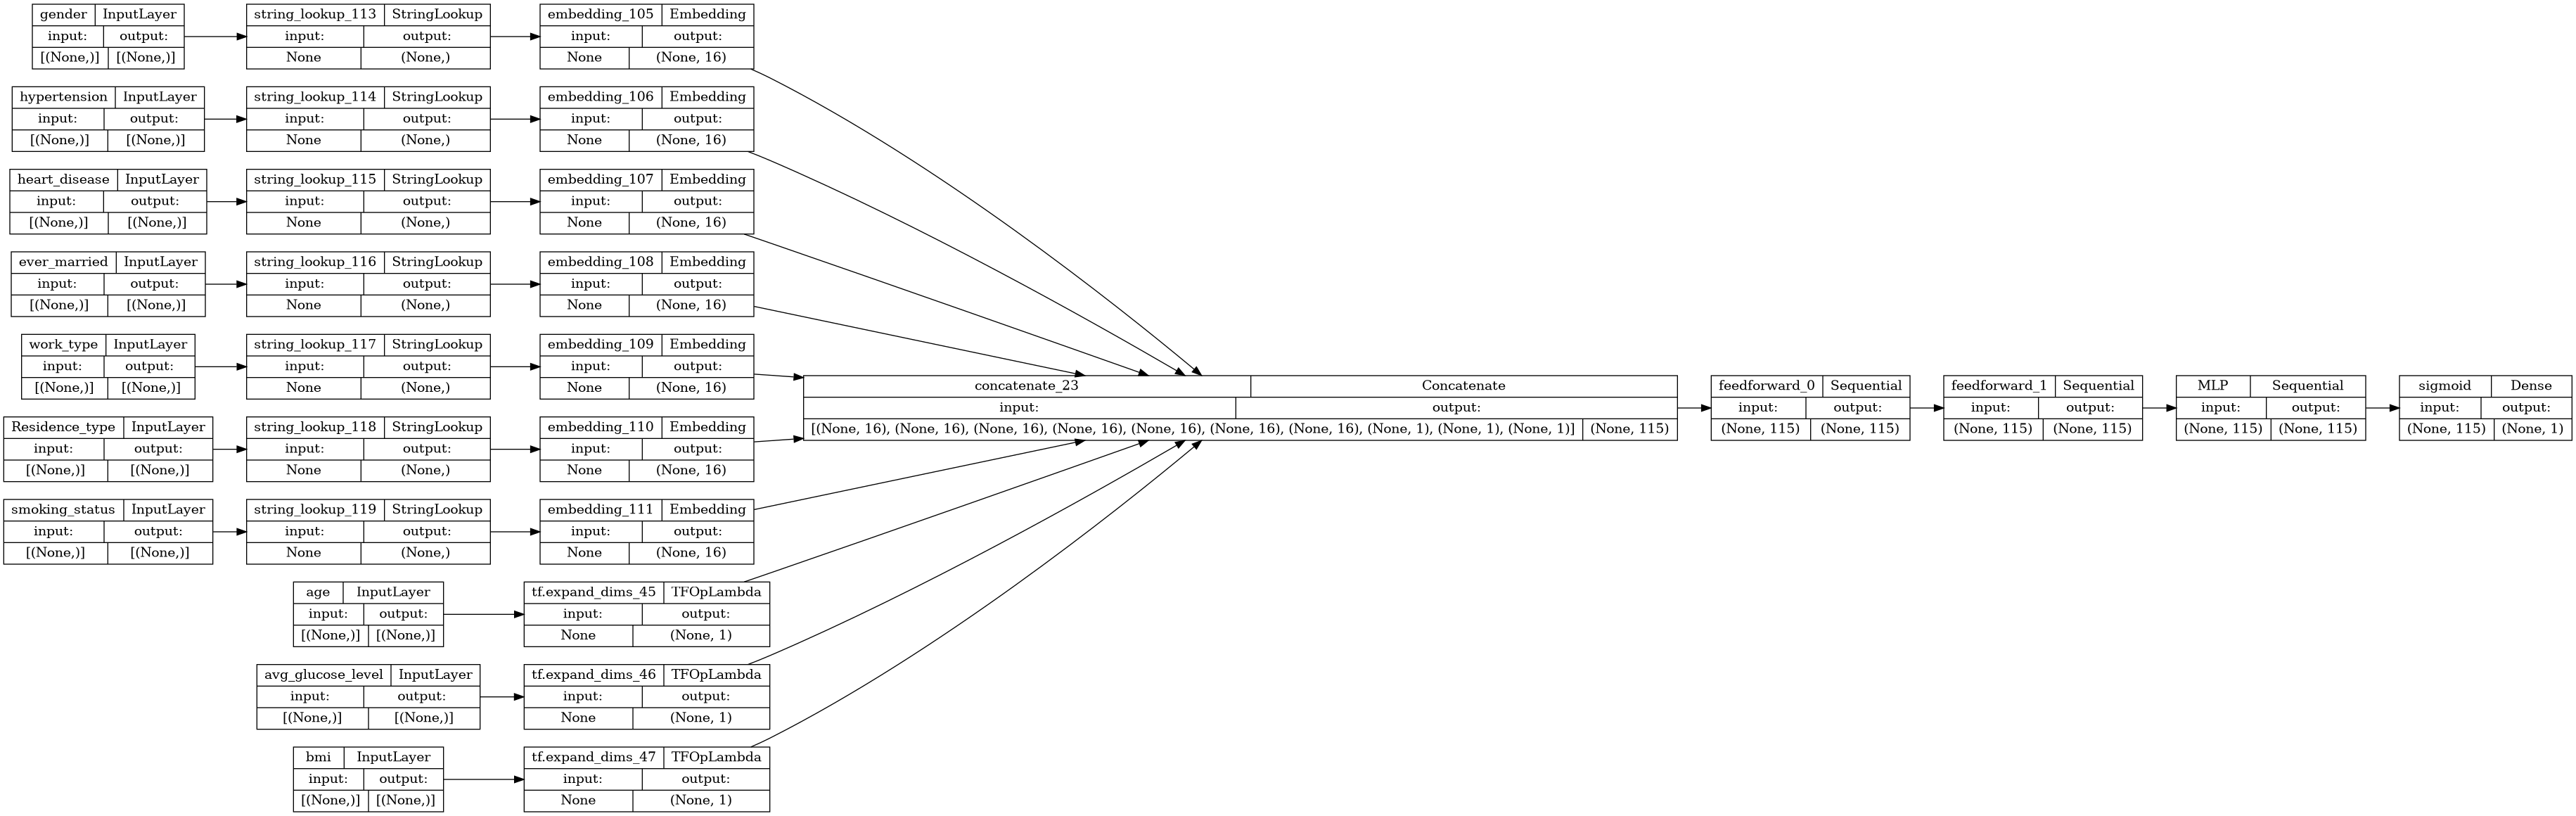

In [206]:
# define a baseline model without transformer layer

baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [207]:
# train baseline model with training set and evaluate with validation set

history, mlp_trained = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=validation_data_file,
    model_output=MLP_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
187/187 [==============================] - 5s 10ms/step - loss: 0.4518 - accuracy: 0.7931 - val_loss: 0.6344 - val_accuracy: 0.5300
Epoch 2/100
187/187 [==============================] - 1s 6ms/step - loss: 0.4042 - accuracy: 0.8208 - val_loss: 0.6046 - val_accuracy: 0.5640
Epoch 3/100
187/187 [==============================] - 1s 7ms/step - loss: 0.3860 - accuracy: 0.8285 - val_loss: 0.8019 - val_accuracy: 0.5260
Epoch 4/100
187/187 [==============================] - 1s 6ms/step - loss: 0.3669 - accuracy: 0.8439 - val_loss: 0.5755 - val_accuracy: 0.6760
Epoch 5/100
187/187 [==============================] - 1s 6ms/step - loss: 0.3390 - accuracy: 0.8559 - val_loss: 0.6026 - val_accuracy: 0.6900
Epoch 6/100
187/187 [==============================] - 1s 6ms/step - loss: 0.3238 - accuracy: 0.8668 - val_loss: 0.5345 - val_accuracy: 0.6740
Epoch 7/100
187/187 [==============================] - 1s 7ms/step - loss: 0.3130 - accuracy: 0.8722 - val_loss: 

INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


Model training finished
Validation accuracy: 77.8%


In [208]:
# Now, train on validation set and evalate with test set

history, mlp_trained = run_experiment(
    model=mlp_trained,
    train_data_file=validation_data_file,
    test_data_file=test_data_file,
    model_output=MLP_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
16/16 [==============================] - 4s 51ms/step - loss: 0.6803 - accuracy: 0.8120 - val_loss: 0.4382 - val_accuracy: 0.9148
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.3055 - accuracy: 0.9000 - val_loss: 0.3621 - val_accuracy: 0.9044
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.2698 - accuracy: 0.9060 - val_loss: 0.3584 - val_accuracy: 0.9023
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.1961 - accuracy: 0.9260 - val_loss: 0.3289 - val_accuracy: 0.9272
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1737 - accuracy: 0.9320 - val_loss: 0.3354 - val_accuracy: 0.9293
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.2097 - accuracy: 0.9300 - val_loss: 0.3470 - val_accuracy: 0.9210
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1723 - accuracy: 0.9340 - val_loss: 0.3438 -

INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets


Model training finished
Validation accuracy: 92.31%


In [209]:
# train tabtransformer model on training data and evaluate on validation data

history, tt_trained = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=validation_data_file,
    model_output=TABTRANSFORMER_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
187/187 [==============================] - 13s 34ms/step - loss: 0.5461 - accuracy: 0.7499 - val_loss: 1.5517 - val_accuracy: 0.2700
Epoch 2/100
187/187 [==============================] - 3s 18ms/step - loss: 0.4881 - accuracy: 0.7725 - val_loss: 0.6168 - val_accuracy: 0.6640
Epoch 3/100
187/187 [==============================] - 3s 16ms/step - loss: 0.4522 - accuracy: 0.7883 - val_loss: 0.7890 - val_accuracy: 0.6060
Epoch 4/100
187/187 [==============================] - 3s 16ms/step - loss: 0.4396 - accuracy: 0.7928 - val_loss: 0.7418 - val_accuracy: 0.5960
Epoch 5/100
187/187 [==============================] - 3s 16ms/step - loss: 0.4275 - accuracy: 0.8017 - val_loss: 0.8204 - val_accuracy: 0.5780
Epoch 6/100
187/187 [==============================] - 3s 16ms/step - loss: 0.4163 - accuracy: 0.8057 - val_loss: 0.6984 - val_accuracy: 0.6200
Epoch 7/100
187/187 [==============================] - 3s 15ms/step - loss: 0.4169 - accuracy: 0.8069 - val

INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


Model training finished
Validation accuracy: 69.0%


In [210]:
# Now, train tabtransformer model on validation data and evaluate on test data

history, tt_trained = run_experiment(
    model=tt_trained,
    train_data_file=validation_data_file,
    test_data_file=test_data_file,
    model_output=TABTRANSFORMER_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
16/16 [==============================] - 8s 89ms/step - loss: 0.5345 - accuracy: 0.7660 - val_loss: 0.3318 - val_accuracy: 0.9002
Epoch 2/100
16/16 [==============================] - 0s 25ms/step - loss: 0.2494 - accuracy: 0.9280 - val_loss: 0.2901 - val_accuracy: 0.9231
Epoch 3/100
16/16 [==============================] - 0s 21ms/step - loss: 0.2067 - accuracy: 0.9220 - val_loss: 0.2777 - val_accuracy: 0.9106
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1824 - accuracy: 0.9420 - val_loss: 0.2786 - val_accuracy: 0.9189
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1606 - accuracy: 0.9440 - val_loss: 0.2686 - val_accuracy: 0.9189
Epoch 6/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1643 - accuracy: 0.9480 - val_loss: 0.2783 - val_accuracy: 0.9210
Epoch 7/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1434 - accuracy: 0.9560 - val_loss: 0.2979 -

INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


Model training finished
Validation accuracy: 90.85%
